In [1]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
import scipy
from functools import partial
from jax.test_util import check_grads
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import cubature, extended, gauss_hermite
from parsmooth.methods import iterated_smoothing
from bearings_utils import make_parameters
from bearing_data import get_data


In [2]:
linearization_method = extended

s1 = jnp.array([-1., 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
# r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.1  # discretization noise
qw = 0.1  # discretization noise

r_true = 0.05

T = 50
_, true_states, ys = get_data(x0, dt, r_true, T, s1, s2)
Q, R, observation_function, transition_function = make_parameters(qc, qw, r_true, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)
chol_R = jnp.linalg.cholesky(R)

m0 = jnp.array([2., 0, 0, 0, 0])
P0 = jnp.diag(jnp.array([0.5**2, 0.5**2, 0.5**2, 0.5**2, 1.]))
chol_P0 = scipy.linalg.cholesky(P0)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)

initial_states =  MVNStandard(jnp.repeat(jnp.array([[2., 0, 0, 0, 0]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[2., 0, 0, 0, 0]]),T + 1, axis=0),
                              jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))




# Standard form
theta = R_true

iterated_res_seq, ell = iterated_smoothing(observations, chol_init, sqrt_transition_model, sqrt_observation_model,
                                                      cubature, initial_points_sqrt, True,
                                                      criterion=lambda i, *_: i < iteration,
                                                      return_loglikelihood = True)



In [3]:
@jax.jit
def get_ell(r):
    R = jnp.diag(jnp.array([r**2, 0.1**2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))  
    iterated_res_seq, ell = iterated_smoothing(ys, init, transition_model, observation_model,
                                               extended, initial_states, False,
                                               criterion=lambda i, *_: i < 20,
                                               return_loglikelihood = True)
    return ell

grad_ell = jax.jit(jax.value_and_grad(get_ell))

In [4]:
grad_ell(0.1)

(DeviceArray(108.49116423, dtype=float64),
 DeviceArray(-378.00523076, dtype=float64, weak_type=True))

In [6]:
check_grads(get_ell, (0.05,), 1, modes=["rev"], atol=1e-7, rtol=1e-7)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=1e-07
VJP cotangent projection
Mismatched elements: 1 / 1 (100%)
Max absolute difference: 0.01094642
Max relative difference: 9.4164202e-05
 x: array(-116.259113)
 y: array(-116.248166)

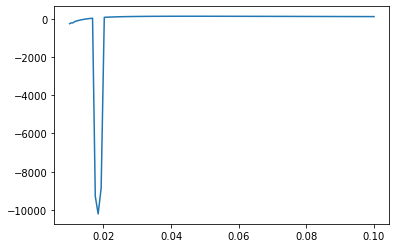

In [9]:
plt.plot(np.logspace(-2, -1), np.array(jax.vmap(lambda r: grad_ell(r)[0])(jnp.logspace(-2, -1))))